## Frontier Population Expansion

This notebook imports census data from 1790 to 2010 and visualizes the population changes in US counties over time.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import zipfile
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image


In [2]:
df = pd.read_excel('data/county2010_hist_pops.xlsx')
exclude_states = ['Alaska', 'Hawaii']
df = df[~df['STATE'].isin(exclude_states)]
df.head(2)

,GISJOIN,GEOID10,STATE,COUNTY,epop1790,epop1800,epop1810,epop1820,epop1830,epop1840,...,epop1920,epop1930,epop1940,epop1950,epop1960,epop1970,epop1980,epop1990,epop2000,pop2010
0,G0100010,1001,Alabama,Autauga,0.0,0.000000,0.000000,2313.138166,6331.545705,7684.043573,...,18908.0,19694.0,20977.0,18186.0,18739.0,24460.0,32259.0,34222.0,43671,54571
1,G0100030,1003,Alabama,Baldwin,0.0,21.678121,25.975907,646.006025,1792.315743,2262.873599,...,20730.0,28289.0,32324.0,40997.0,49088.0,59382.0,78556.0,98280.0,140415,182265


### Load the county shapefile into a geopandas DataFrame

In [3]:
zip_path = 'map_data/cb_2024_us_county_20m.zip'
extract_dir = 'map_data/temp'

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_dir)

# List files in the extracted directory to verify shapefile name
print('Extracted files:', os.listdir(extract_dir))

# Find the .shp file in the extracted directory
shp_files = [f for f in os.listdir(extract_dir) if f.endswith('.shp')]
if shp_files:
    shapefile_path = os.path.join(extract_dir, shp_files[0])
    gdf = gpd.read_file(shapefile_path)
    # Exclude Alaska (02), Hawaii (15), and Puerto Rico (72) using STATEFP column
    exclude_fips = ['02', '15', '72']
    gdf = gdf[~gdf['STATEFP'].isin(exclude_fips)]
    print(gdf.head(2))
else:
    print('No .shp file found in extracted directory.')

Extracted files: ['cb_2024_us_county_20m.cpg', 'cb_2024_us_county_20m.dbf', 'cb_2024_us_county_20m.prj', 'cb_2024_us_county_20m.shp', 'cb_2024_us_county_20m.shp.ea.iso.xml', 'cb_2024_us_county_20m.shp.iso.xml', 'cb_2024_us_county_20m.shx']
  STATEFP COUNTYFP  COUNTYNS         GEOIDFQ  GEOID      NAME  \
0      18      087  00450368  0500000US18087  18087  LaGrange   
1      20      107  00485018  0500000US20107  20107      Linn   

          NAMELSAD STUSPS STATE_NAME LSAD       ALAND    AWATER  \
0  LaGrange County     IN    Indiana   06   983242853  18311996   
1      Linn County     KS     Kansas   06  1538662703  31893232   

                                            geometry  
0  POLYGON ((-85.65975 41.75924, -85.29218 41.759...  
1  POLYGON ((-95.06583 38.38994, -94.61277 38.388...  


In [4]:
gdf[gdf.STATE_NAME=='Alabama'].head(2)

,STATEFP,COUNTYFP,COUNTYNS,GEOIDFQ,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
137,01,093,00161573,0500000US01093,01093,Marion,Marion County,AL,Alabama,06,1922657200,3183480,"POLYGON ((-88.20358 34.08653, -88.17326 34.321..."
288,01,133,00161592,0500000US01133,01133,Winston,Winston County,AL,Alabama,06,1587660956,48870378,"POLYGON ((-87.63472 34.307, -87.52972 34.3046,..."


In [5]:
# Ensure both keys are string type before merging
gdf['GEOID'] = gdf['GEOID'].astype(str)
df['GEOID10'] = df['GEOID10'].astype(str)

# Select columns to merge from df
merge_cols = ['GEOID10'] + [col for col in df.columns[4:]]

# Merge selected columns from df to gdf using GEOID (gdf) and GEOID10 (df)
gdf_merged = gdf.merge(df[merge_cols], left_on='GEOID', right_on='GEOID10', how='left')

# Display the first few rows of the merged GeoDataFrame
gdf_merged.head(2)

,STATEFP,COUNTYFP,COUNTYNS,GEOIDFQ,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,...,epop1920,epop1930,epop1940,epop1950,epop1960,epop1970,epop1980,epop1990,epop2000,pop2010
0,18,087,00450368,0500000US18087,18087,LaGrange,LaGrange County,IN,Indiana,06,...,14009.0,13780.0,14352.0,15347.0,17380.0,20890.0,25550.0,29477.0,34909.0,37128.0
1,20,107,00485018,0500000US20107,20107,Linn,Linn County,KS,Kansas,06,...,13815.0,13534.0,11969.0,10053.0,8274.0,7770.0,8234.0,8254.0,9564.0,9656.0


### County population maps and animation

c:\Users\jonat\miniforge3\envs\gnn_env\Lib\site-packages\mapclassify\classifiers.py:1767: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 3.
  self.bins = quantile(y, k=k)


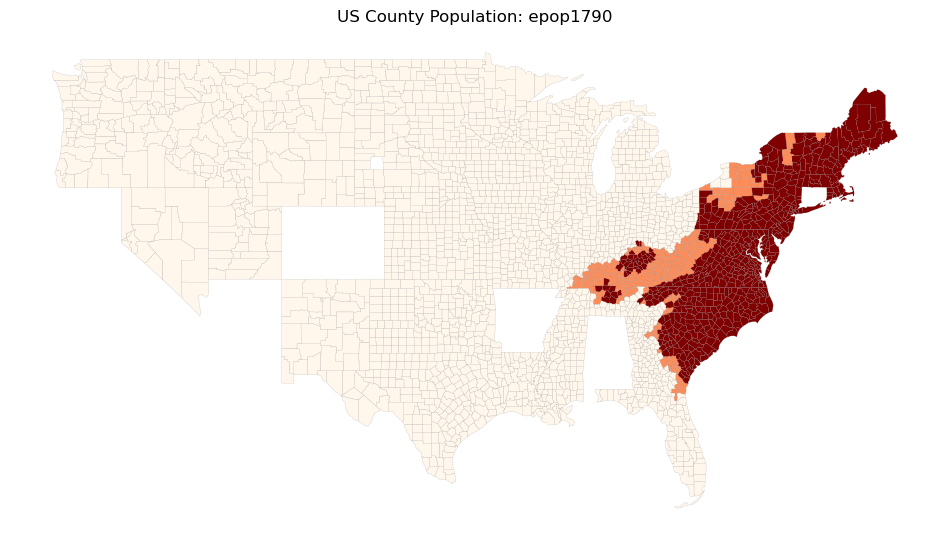

In [6]:
pop_columns = df.columns[4:]  # (epop1790, epop1800, ..., pop2010)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

def update(frame):
    ax.clear()
    col = pop_columns[frame]
    gdf_merged.plot(
        column=col,
        cmap='OrRd',
        linewidth=0.1,
        ax=ax,
        edgecolor='gray',
        legend=False,
        scheme='quantiles'
    )
    ax.set_title(f'US County Population: {col}')
    ax.axis('off')
    # Save each frame as an image
    plt.savefig(f'map_data/frames/{col}.png', bbox_inches='tight')

ani = FuncAnimation(fig, update, frames=len(pop_columns), repeat=False, interval=800)

In [7]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ani.save('county_population_animation.gif', writer='pillow')
    

<Figure size 640x480 with 0 Axes>

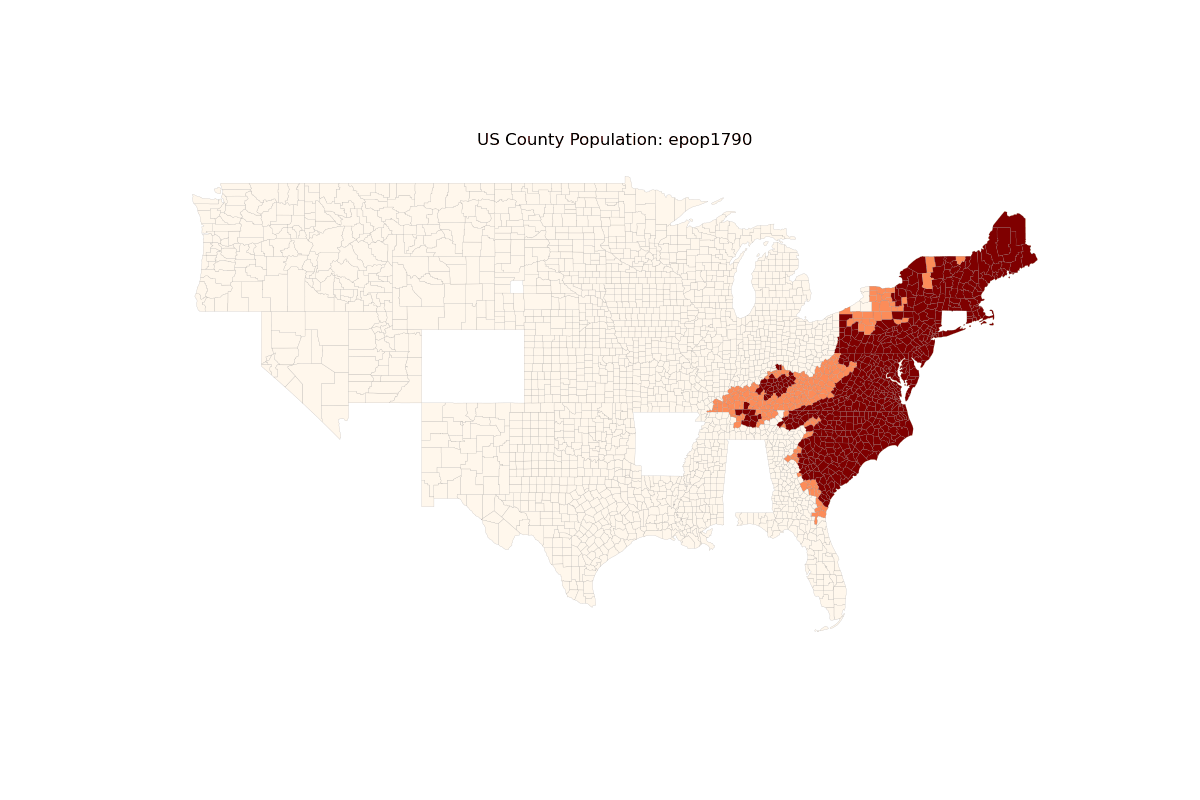

In [8]:
Image(filename='county_population_animation.gif')